# **FLM Project**
**Teo Nordström**

Template by Johan Hoffman

# **Abstract**

Project code testing flaps.

# **About the code**

In [283]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [284]:
# Load neccessary modules.
import numpy as np
from math import radians, floor
import time

# Install FEniCS (this may take a long time)
import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=250km/h=69.44m/s$), and $D$ the characteristic length scale (here $D$ is the chord of the wing).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Get polygon and chord**

In [285]:
wing_tip_point = 3
flap_tip_point = 1
str_mod = ""

# Define rectangular domain
L = 8
H = 8

Lpos = 2.25
Hpos = 4.1
mirror_x = False

angle = 0
if angle >= 0:
    mirror_y = False
    rads = radians(-angle)
else:
    mirror_y = True
    rads = radians(angle)

basewing = [np.array([0.0, 0.0]), np.array([-0.5, 0]), np.array([-1.0, 0]), np.array([-1.25, -0.1]),
            np.array([-1.0, -0.2]), np.array([-0.5, -0.2])]

flap = [np.array([0.0, 0.0]), np.array([1, -0.1]), np.array([0.0, -0.2])]

rot_mat = np.array([[np.cos(rads), -np.sin(rads)], [np.sin(rads), np.cos(rads)]])

for i in range(len(flap)):
    flap[i] = rot_mat @ flap[i]

flap_backpoint = np.array((0.0, -0.2))

if flap_backpoint.all() != flap[-1].all():
    slope_wing = (flap_backpoint[1] - basewing[-1][1]) / (flap_backpoint[0] - basewing[-1][0])
    slope_flap = (flap[-1][1] - flap[-2][1]) / (flap[-1][0] - flap[-2][0])
    x_intersect = (slope_wing * basewing[-1][0] - slope_flap * flap[-2][0] - basewing[-1][1] + flap[-2][1]) / (
                slope_wing - slope_flap)
    y_intersect = slope_wing * (x_intersect - basewing[-1][0]) + basewing[-1][1]

    flap[-1] = np.array([x_intersect, y_intersect])

flap.reverse()

if mirror_y:
    flip_y_mat = np.array([[1.0, 0.0], [0.0, -1.0]])
    Hpos = H - Hpos
    for i in range(len(flap)):
        flap[i] = flip_y_mat @ flap[i]
    for i in range(len(basewing)):
        basewing[i] = flip_y_mat @ basewing[i]
if mirror_x:
    str_mod += "back"
    flip_x_mat = np.array([[-1.0, 0.0], [0.0, 1.0]])
    Lpos = Lpos - 0.25
    for i in range(len(flap)):
        flap[i] = flip_x_mat @ flap[i]
    for i in range(len(basewing)):
        basewing[i] = flip_x_mat @ basewing[i]


winglist = []
for point in basewing:
    winglist.append(Point(point[0] + Lpos, point[1] + Hpos))
for point in flap:
    winglist.append(Point(point[0] + Lpos, point[1] + Hpos))
chord = round(np.sqrt(np.power(basewing[3][0] - flap[flap_tip_point][0], 2) + np.power(basewing[3][1] - flap[flap_tip_point][1], 2)), 4)
print(chord)

if (mirror_y or mirror_x) and not (mirror_y and mirror_x):
    winglist.reverse()

2.25


**Define domain and mesh**

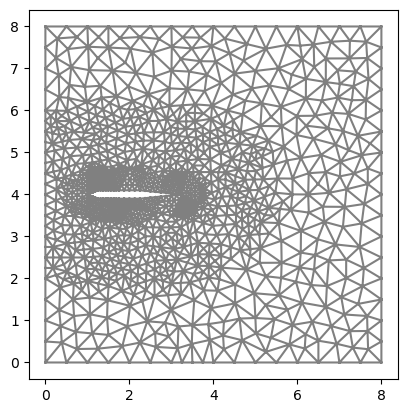

In [286]:
# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 16
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
wing = Polygon(winglist)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - wing, resolution)

# Local mesh refinement (specified by winglist)
no_levels = 2
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    for pt in winglist:
      if p.distance(pt) < 2.0 / ((i + 1) * (i + 1)):
          cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.savefig(f"{str_mod}resultfigs/meshangle{angle}.png")
plt.show()

**Define finite element approximation spaces**

In [287]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [288]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [289]:
# Set viscosity
nu = 4.0e-3

**Calculate Reynolds Number**

As stated in the introduction, the Reynolds number is defined as $Re=\frac{UD}{\nu}$.

In [290]:
Re = (uin * chord) / nu
print("Reynolds Number:", Re)

Reynolds Number: 562.5


**Define method parameters**

In [291]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [292]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute Boundary Expression**

In [293]:
expr = ""

for i in range(len(winglist) - 1):
  expr += f"near(pow({winglist[i].x()}-x[0],2)+pow({winglist[i].y()}-x[1],2)+pow({winglist[i+1].x()}-x[0],2)+pow({winglist[i+1].y()}-x[1],2),pow({winglist[i].x()}-{winglist[i+1].x()},2)+pow({winglist[i].y()}-{winglist[i+1].y()},2)) || "
i = len(winglist) - 1
expr += f"near(pow({winglist[i].x()}-x[0],2)+pow({winglist[i].y()}-x[1],2)+pow({winglist[0].x()}-x[0],2)+pow({winglist[0].y()}-x[1],2),pow({winglist[i].x()}-{winglist[0].x()},2)+pow({winglist[i].y()}-{winglist[0].y()},2))"

**Compute force on boundary**

In [294]:
#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
#psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi_expression_l = Expression(("0",f"{expr} ? 1. : 0."), element = V.ufl_element())
psi_l = interpolate(psi_expression_l, V)

psi_expression_d = Expression((f"{expr} ? 1. : 0.","0."), element = V.ufl_element())
psi_d = interpolate(psi_expression_d, V)

Force_l = inner((u1 - u0)/dt + grad(um1)*um1, psi_l)*dx - p1*div(psi_l)*dx + nu*inner(grad(um1), grad(psi_l))*dx
Force_d = inner((u1 - u0)/dt + grad(um1)*um1, psi_d)*dx - p1*div(psi_d)*dx + nu*inner(grad(um1), grad(psi_d))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
normalization = -2.0/chord

**Set plotting variables and open export files**

In [295]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 35
plot_freq = 10

# Force computation data
force_array_l = np.array(0.0)
force_array_l = np.delete(force_array_l, 0)
force_array_d = np.array(0.0)
force_array_d = np.delete(force_array_d, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [296]:
!rm results-NS/*

# Time stepping
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F_l = assemble(Force_l)
        F_d = assemble(Force_d)
        if (t > start_sample_time):
          force_array_l = np.append(force_array_l, normalization*F_l)
          force_array_d = np.append(force_array_d, normalization*F_d)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Lift Force")
        plt.plot(time, force_array_l)
        plt.show()

        plt.figure()
        plt.title("Drag Force")
        plt.plot(time, force_array_d)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

s = 'Time t = ' + repr(t)
print(s)

# Plot solution
plt.figure()
plot(u1, title="Velocity")
plt.savefig(f"{str_mod}resultfigs/velangle{angle}.png")

plt.figure()
plot(p1, title="Pressure")
plt.savefig(f"{str_mod}resultfigs/presangle{angle}.png")

plt.show()

plt.figure()
plt.title("Lift Force")
plt.plot(time, force_array_l)
plt.savefig(f"{str_mod}resultfigs/lforceangle{angle}.png")
plt.show()

plt.figure()
plt.title("Drag Force")
plt.plot(time, force_array_d)
plt.savefig(f"{str_mod}resultfigs/dforceangle{angle}.png")
plt.show()

if abs(angle) > 22:
    checks = floor(len(force_array_l) / 5)
    max_l = max(force_array_l[-checks:])
    min_l = min(force_array_l[-checks:])
    max_pos = np.where(force_array_l[-checks:]==max_l)[0][0]
    min_pos = np.where(force_array_l[-checks:]==min_l)[0][0]
    max_d = max(force_array_d[-checks:])
    min_d = min(force_array_d[-checks:])

    c_l_max = (2 * max_l) / chord
    c_d_max = (2 * max_d) / chord
    c_l_min = (2 * min_l) / chord
    c_d_min = (2 * min_d) / chord

    period = abs(time[max_pos] - time[min_pos]) * 2
    st = (1 / period) * chord
    
    with open("endforces.txt", "a") as file:
        file.write(f"{str_mod}{angle},{chord},{Re},{min_l},{max_l},{min_d},{max_d},{c_l_min},{c_l_max},{c_d_min},{c_d_max},{period},{st}\n")
else:
    print(f"Lift Force at end: {force_array_l[-1]}")
    
    c_l = (2 * force_array_l[-1]) / chord
    c_d = (2 * force_array_d[-1]) / chord
    
    with open("endforces.txt", "a") as file:
        file.write(f"{str_mod}{angle},{chord},{Re},{force_array_l[-1]},{force_array_l[-1]},{force_array_d[-1]},{force_array_d[-1]},{c_l},{c_l},{c_d},{c_d},0,0\n")

rm: cannot remove 'results-NS/*': No such file or directory


KeyboardInterrupt: 

# **Discussion**